In [2]:
import torch
from data.data import generate_sample
from model.dntm.DynamicNeuralTuringMachine import DynamicNeuralTuringMachine
from model.dntm.DynamicNeuralTuringMachineMemory import DynamicNeuralTuringMachineMemory

from utils.wandb_utils import log_params_norm, log_weights_gradient

In [3]:
import seaborn as sns

In [4]:
from IPython.core.debugger import set_trace

## Data

In [5]:
vocab_chars = set('abcdefghijklmnopqrstuvwxyz0123456789()+*-=<>: ')
vocab_size = len(vocab_chars) + 1
target_vocab_chars = set('0123456789-')
target_vocab_size = len(target_vocab_chars)

token2pos = {t: p for p, t in enumerate(vocab_chars)}
token2pos['\n'] = len(token2pos)
target_token2pos = {t: p for p, t in enumerate(target_vocab_chars)}

In [6]:
pos2token = {p: t for t, p in token2pos.items()}

In [7]:
def make_1hot(char, token2pos, vocab_size):
    onehot_vec = torch.zeros((1, vocab_size))
    onehot_vec[0, token2pos[char]] = 1
    return onehot_vec

In [8]:
def make_tensor(sample, token2pos, vocab_size):
    sample_tensor = []
    for c in sample:
        sample_tensor.append(make_1hot(c, token2pos, vocab_size))
    return torch.concat(sample_tensor).unsqueeze(dim=0)

### Sample

In [9]:
x, y = generate_sample(length=2, nesting=1)
print(x)
print(y)
exec(x)

q=95
for i in range(1): q-=46
print(q)
49
49


In [10]:
x_t, y_t = make_tensor(x, token2pos, vocab_size), make_tensor(y, token2pos, vocab_size)

In [11]:
assert x_t.size(1) == len(x)
assert y_t.size(1) == len(y)

### Samples

In [12]:
few_samples = [generate_sample(length=2, nesting=1) for i in range(100)]
few_tensor_samples = [(make_tensor(x, token2pos, vocab_size), make_tensor(y, token2pos, vocab_size))
                      for x, y in few_samples]

In [13]:
def get_sample(few_tensor_samples):
    return few_tensor_samples[torch.randint(len(few_tensor_samples), (1,)).item()]

### Batch

In [13]:
sorted(few_samples, key=lambda x: (len(x[0]), len(x[1])))

[('j=0\nprint(j)', '0'),
 ('t=7\nprint(t)', '7'),
 ('j=5\nprint(j)', '5'),
 ('c=7\nprint(c)', '7'),
 ('m=79\nprint(m)', '79'),
 ('x=12\nprint(x)', '12'),
 ('g=43\nprint(g)', '43'),
 ('w=36\nprint(w)', '36'),
 ('m=34\nprint(m)', '34'),
 ('print((55+0))', '55'),
 ('z=35\nprint(z)', '35'),
 ('x=28\nprint(x)', '28'),
 ('p=35\nprint(p)', '35'),
 ('print((96-8))', '88'),
 ('a=22\nprint(a)', '22'),
 ('z=80\nprint(z)', '80'),
 ('m=25\nprint(m)', '25'),
 ('print((0+80))', '80'),
 ('print((22*5))', '110'),
 ('print((4-80))', '-76'),
 ('print((9-27))', '-18'),
 ('print((27-22))', '5'),
 ('print((51+46))', '97'),
 ('print((99-29))', '70'),
 ('print((12+39))', '51'),
 ('print((97-12))', '85'),
 ('print((62+19))', '81'),
 ('print((33+61))', '94'),
 ('print((24+12))', '36'),
 ('print((42-27))', '15'),
 ('print((82-72))', '10'),
 ('print((48+13))', '61'),
 ('print((70-17))', '53'),
 ('print((57+19))', '76'),
 ('print((28+68))', '96'),
 ('print((51-33))', '18'),
 ('print((40-43))', '-3'),
 ('print((15+

In [14]:
equal_len_samples = [[('g=61\nfor i in range(6): g+=48\nprint(g)', '349'), 
                     ('r=62\nfor i in range(5): r+=48\nprint(r)', '302')],
                    [('t=67\nprint(t)', '67'),
                     ('s=12\nprint(s)', '12'),],
                    [('print((54*69))', '3726'),
                     ('print((80*57))', '4560'),],
                    [('a=36\nfor i in range(4): a-=96\nprint(a)', '-348'),
                     ('l=24\nfor i in range(3): l-=74\nprint(l)', '-198')],
                    [('print((6-1))', '5'),
                     ('y=0\nprint(y)', '0')],
                    [('l=84\nfor i in range(0): l+=39\nprint(l)', '84'),
                     ('w=94\nfor i in range(0): w+=93\nprint(w)', '94')],
                    [('l=74\nfor i in range(2): l+=51\nprint(l)', '176'),
                     ('y=49\nfor i in range(7): y+=52\nprint(y)', '413'),],
                    [('print((28 if 77<71 else 42))', '42'),
                     ('print((60 if 19<12 else 19))', '19'),],
                    [('print((61 if 66<15 else 36))', '36'),
                     ('print((21 if 72>50 else 65))', '21'),],
                    [('print((35*82))', '2870'),
                     ('print((69*18))', '1242')]]

In [15]:
batched_samples = torch.concat([make_tensor(x, token2pos, vocab_size) for x, y in equal_len_samples[0]])
batched_targets = torch.concat([make_tensor(y, token2pos, vocab_size) for x, y in equal_len_samples[0]])

### Batches

In [16]:
equal_len_tensor_samples = [torch.concat([make_tensor(x, token2pos, vocab_size) for x, y in equal_len_batch])
                            for equal_len_batch in equal_len_samples]
equal_len_tensor_targets = [torch.concat([make_tensor(y, token2pos, vocab_size) for x, y in equal_len_batch])
                            for equal_len_batch in equal_len_samples]

In [17]:
def get_batch(equal_len_tensor_samples, equal_len_tensor_targets):
    i = torch.randint(len(equal_len_samples), (1,)).item()
    return (equal_len_tensor_samples[i],
            equal_len_tensor_targets[i])

### Padded batch

In [14]:
few_samples = [generate_sample(length=2, nesting=1) for i in range(16)]
samples_len = [len(x) for x, y in few_samples]
targets_len = [len(y) for x, y in few_samples]

In [15]:
tensor_samples = [make_tensor(x, token2pos, vocab_size) for x, y in few_samples]
tensor_targets = [make_tensor(y, token2pos, vocab_size) for x, y in few_samples]

In [20]:
padded_tensor_samples = [torch.concat((t, torch.zeros((1, max(samples_len)-l, vocab_size))), dim=1)
                         for t, l in zip(tensor_samples, samples_len)]
padded_samples_batch = torch.concat(padded_tensor_samples)

In [21]:
padded_tensor_targets = [torch.concat((t, torch.zeros((1, max(targets_len)-l, vocab_size))), dim=1)
                         for t, l in zip(tensor_targets, targets_len)]
padded_targets_batch = torch.concat(padded_tensor_targets)

### Padded batches

In [1]:
def make_padded_batch(tensors, lens):
    padded_tensors = [torch.concat((t, torch.zeros((1, max(lens)-l, vocab_size))), dim=1)
                      for t, l in zip(tensors, lens)]
    return torch.concat(padded_tensors)  # make batch

In [83]:
few_batches = [[generate_sample(length=2, nesting=1) for i in range(16)] for j in range(12)]
samples_len_batches = [[len(x) for x, y in few_samples] for few_samples in few_batches]
targets_len_batches = [[len(y) for x, y in few_samples] for few_samples in few_batches]

In [84]:
tensor_samples_batches = [[make_tensor(x, token2pos, vocab_size) for x, y in few_samples] for few_samples in few_batches]
tensor_targets_batches = [[make_tensor(y, token2pos, vocab_size) for x, y in few_samples] for few_samples in few_batches]

In [85]:
padded_samples_batches = [make_padded_batch(t, l) for t, l in zip(tensor_samples_batches, samples_len_batches)]
padded_targets_batches = [make_padded_batch(t, l) for t, l in zip(tensor_targets_batches, targets_len_batches)]

In [86]:
def get_padded_batch(padded_samples_batches, padded_targets_batches, samples_len_batches, targets_len_batches):
        i = torch.randint(len(padded_samples_batches), (1,)).item()
        return (padded_samples_batches[i],
                padded_targets_batches[i],
                samples_len_batches[i],
                targets_len_batches[i])

## Model

In [28]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm_cell = torch.nn.LSTMCell(
            input_size=input_size,
            hidden_size=hidden_size)
        self.W_o = torch.nn.Parameter(torch.rand(output_size, hidden_size))
        self.b_o = torch.nn.Parameter(torch.rand(1))
        self.register_buffer("h_t", torch.zeros(16, hidden_size))
        self.register_buffer("c_t", torch.zeros(16, hidden_size))
    
    def forward(self, x, hidden_mask):
        self.h_t, self.c_t = self.h_t * hidden_mask, self.c_t * hidden_mask
        self.h_t, self.c_t = self.lstm_cell(x, (self.h_t, self.c_t))
        return self.h_t @ self.W_o.T + self.b_o
    
    def detach_states(self):
        self.h_t = self.h_t.detach()
        self.c_t = self.c_t.detach()
        
    def set_states(self, h_dict, c_dict):
        self.h_t = torch.concat([h for _, h in h_dict.items()])
        self.c_t = torch.concat([c for _, c in c_dict.items()])

In [29]:
def train(model, sample, target, loss, opt):
    opt.zero_grad()
    outputs = []

    for char_pos in range(sample.size(1)):
        output = model(sample[:, char_pos, :].squeeze())
    outputs.append(output)

    for char_pos in range(target.size(1) - 1):
        output = model(target[:, char_pos, :].squeeze())
        outputs.append(output)
    
    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        cumulative_loss += loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1))
    avg_loss = cumulative_loss / len(outputs)

    avg_loss.backward()
    opt.step()

    model.detach_states()
    return avg_loss.item()

In [30]:
def reduce_lens(lens):
    return [l-1 if l > 0 else l for l in lens]

In [31]:
def get_mask(lens):
    return torch.tensor([1 if l > 0 else 0 for l in lens])

In [32]:
def get_hidden_mask(mask_1d):
    return torch.concat([torch.zeros((1, 100)) if m == 0 else torch.ones((1, 100)) for m in get_mask(samples_len)], dim=0)

In [93]:
def save_states(model, h_dict, c_dict, samples_len):
    target_states = torch.argwhere(get_mask(samples_len) == 0)
    for state in target_states:
        h_dict.setdefault(state.item(), model.h_t[state, :])
        c_dict.setdefault(state.item(), model.c_t[state, :])
    return h_dict, c_dict

In [94]:
def train_padded(model, sample, target, samples_len, targets_len, loss, opt):
    opt.zero_grad()
    outputs = []
    h_dict, c_dict = {}, {}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()

    for char_pos in range(sample.size(1)):
        h_dict, c_dict = save_states(model, h_dict, c_dict, samples_len)
        mask_1d = get_mask(samples_len)
        hidden_mask = get_hidden_mask(mask_1d)
        output = model(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
    h_dict, c_dict = save_states(model, h_dict, c_dict, samples_len)
    outputs.append(output)
    
    model.set_states(h_dict, c_dict)
    
    targets_len_copy = targets_len.copy()
    for char_pos in range(target.size(1) - 1):
        mask_1d = get_mask(targets_len_copy)
        hidden_mask = get_hidden_mask(targets_len_copy)
        output = model(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)
    
    count_nonzero = 0
    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        loss_mask = get_mask(targets_len)
        targets_len = reduce_lens(targets_len)
        char_loss = loss(output, torch.argmax(target[:, char_pos, :].squeeze(), dim=1)) * loss_mask
        count_nonzero += (char_loss != 0).sum()
        cumulative_loss += torch.sum(char_loss)
    avg_loss = cumulative_loss / count_nonzero
    
    avg_loss.backward()
    opt.step()

    model.detach_states()
    return avg_loss.item()

In [35]:
def train_dntm(model, sample, target, loss, opt):
    opt.zero_grad()
    outputs = []
    
    model.prepare_for_batch(sample, sample.device)
    for char_pos in range(sample.size(1)):
        output = model(sample[:, char_pos, :].reshape(sample.size(2), 2))
    outputs.append(output)

    for char_pos in range(target.size(1) - 1):
        output = model(target[:, char_pos, :].reshape(sample.size(2), 2))
        outputs.append(output)

    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        cumulative_loss += loss(output.squeeze(), torch.argmax(target[:, char_pos, :].squeeze(), dim=1))
    avg_loss = cumulative_loss / len(outputs)

    avg_loss.backward()
    opt.step()

    return avg_loss.item()

In [103]:
model = LSTM(
    input_size=vocab_size,
    hidden_size=100,
    output_size=vocab_size)

In [30]:
dntm_memory = DynamicNeuralTuringMachineMemory(
        n_locations=100,
        content_size=8,
        address_size=8,
        controller_input_size=vocab_size,
        controller_hidden_state_size=100,
    )

In [31]:
dntm = DynamicNeuralTuringMachine(
    memory=dntm_memory,
    controller_hidden_state_size=100,
    controller_input_size=vocab_size,
    controller_output_size=vocab_size,
)

In [73]:
model = dntm

## Train

In [105]:
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
MAX_ITER = 3000

In [173]:
loss_values = []
for step in range(MAX_ITER):
    batched_samples, batched_targets = get_batch(equal_len_tensor_samples, equal_len_tensor_targets)
    loss_values.append(train(model, batched_samples, batched_targets, loss, opt))

NameError: name 'get_batch' is not defined

In [106]:
loss = torch.nn.CrossEntropyLoss(reduction='none')
loss_values = []
for step in range(MAX_ITER):
    (padded_samples_batch, padded_targets_batch,
     samples_len, targets_len) = get_padded_batch(padded_samples_batches, padded_targets_batches,
                                                  samples_len_batches, targets_len_batches)
    loss_values.append(train_padded(model, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, opt))

In [75]:
loss_values = []
for step in range(MAX_ITER):
    # x_t, y_t = get_sample(few_tensor_samples)
    batched_samples, batched_targets = get_batch(equal_len_tensor_samples, equal_len_tensor_targets)
    loss_values.append(train_dntm(model, batched_samples, batched_targets, loss, opt))

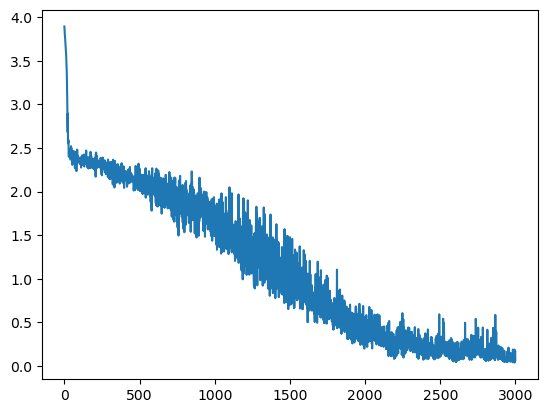

In [107]:
AxesSubplot = sns.lineplot(loss_values)
# _ = AxesSubplot.set(title=f"{x} {y}")

Expected cross-entropy value with random prediction:

In [200]:
torch.log(torch.tensor(vocab_size))

tensor(3.8501)

## Eval

In [201]:
def target_tensors_to_str(y_t):
    idx_outputs = [torch.argmax(o).item() for o in y_t]
    return ''.join([pos2token[idx] for idx in idx_outputs])

In [152]:
# LSTM
sample, target = x_t, y_t

outputs = []
for char_pos in range(sample.size(1)):
    output = model(sample[:, char_pos, :].squeeze())
outputs.append(output)

for char_pos in range(target.size(1) - 1):
    output = model(target[:, char_pos, :].squeeze())
    outputs.append(output)

In [217]:
# D-NTM
sample, target = get_sample(few_tensor_samples)

outputs = []
model.prepare_for_batch(sample, sample.device)
for char_pos in range(sample.size(1)):
    output = model(sample[:, char_pos, :].view(sample.size(2), 1))
outputs.append(output)

for char_pos in range(target.size(1) - 1):
    output = model(target[:, char_pos, :].view(sample.size(2), 1))
    outputs.append(output)

outputs = [o.squeeze() for o in outputs]

In [218]:
target_tensors_to_str(outputs)

'41'

In [219]:
targets = [target[:, i, :].squeeze() for i in range(target.size(1))]
target_tensors_to_str(targets)

'41'